In [1]:
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm
from datetime import datetime
import math
import torch.nn.functional as F

In [2]:
df = pd.read_csv('cleaned_output_vk.csv', encoding='utf-8')
df.head()

,Text
0,Брат ебет сестру. Она ему говорит \n \n-А ты е...
1,Идет суд. Судья: \n— Свидетель Георгадзе! \nТи...
2,"Идет мужик на свидание. В белой рубашечке, кос..."
3,"Многие мужчины очень романтичные и любят, когд..."
4,Дедушка с бабушкой нашли под кроватью у Колобк...


In [3]:
df['Text'].astype(str).to_csv('train_texts.txt', index=False, header=False)

In [4]:
!pip install tokenizers


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from transformers import DataCollatorWithPadding

In [6]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()  # Предварительное разбиение по пробелам

In [7]:
trainer = BpeTrainer(
    vocab_size=10000,  # Размер словаря
    min_frequency=2,  # Игнорировать пары, встречающиеся реже 2 раз
    special_tokens=["[PAD]", "[EOS]"]
)

In [8]:
tokenizer.train_from_iterator(df['Text'], trainer=trainer)

In [9]:
eos_id = tokenizer.token_to_id("[EOS]")
tokenizer.post_processor = TemplateProcessing(
    single="$A [EOS]",
    special_tokens=[("[EOS]", eos_id)]
)

In [10]:
df['Tokenized'] = df['Text'].apply(lambda x: tokenizer.encode(x).ids)

Text(0.5, 1.0, 'length Distribution')

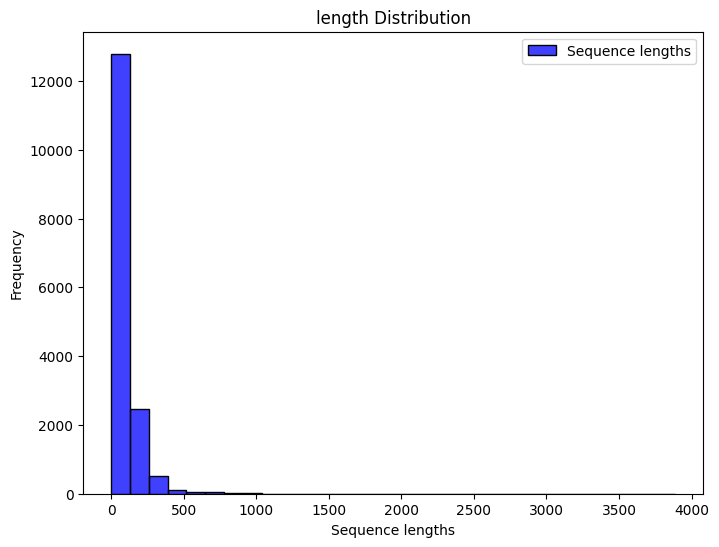

In [11]:
seq_lengths = [len(row['Tokenized']) for idx, row in df.iterrows()]

plt.figure(figsize=(8, 6))
sns.histplot(seq_lengths, color='blue', label='Sequence lengths', kde=False, bins=30)
plt.xlabel("Sequence lengths")
plt.ylabel("Frequency")
plt.legend()
plt.title("length Distribution")

In [12]:
sample_text = df['Text'].iloc[0]
encoded = tokenizer.encode(sample_text)
print(f"Исходный текст: {sample_text}")
print(f"Токенизированные ID: {encoded.ids}")
print(f"Декодированный текст: {tokenizer.decode(encoded.ids)}")

Исходный текст: Брат ебет сестру. Она ему говорит 
 
-А ты ебешься лучше чем отец. 
 
-Я знаю, мне мама говорила.
Токенизированные ID: [7023, 4710, 6703, 15, 1320, 739, 728, 14, 173, 708, 9385, 3024, 1615, 903, 1475, 15, 14, 204, 1296, 13, 805, 1727, 6232, 15, 1]
Декодированный текст: Брат ебет сестру . Она ему говорит - А ты ебе шься лучше чем отец . - Я знаю , мне мама говорила .


In [13]:
# for dataset when batching
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True) <- add [PAD] tokens

In [14]:
tokenizer.save("bpe_tokenizer.json")
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")

In [15]:
class PositionalEncoding(nn.Module):
   def __init__(self, d_model, max_len=512):
       super(PositionalEncoding, self).__init__()
       self.d_model = d_model
       self.max_len = max_len

       # Create a positional encoding matrix
       pe = torch.zeros(max_len, d_model)
       position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
       div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
       pe[:, 0::2] = torch.sin(position * div_term)
       pe[:, 1::2] = torch.cos(position * div_term)
       pe = pe.unsqueeze(0)
        
       self.register_buffer('pe', pe)

   def forward(self, x):
       # Add positional embeddings to input token embeddings
       # print(f'pe shape = {self.pe[:, :x.size(1), :].size()}')
       x = x + self.pe[:, :x.size(1), :]

       return x

        

In [16]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        return self.fc2(self.dropout(out))
        

class DecoderBlock(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout):
        super().__init__()
        self.attention =  nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.feedforward = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, cache=None):
        if cache is None:
            attn_output, _ = self.attention(query=x, key=x, value=x, need_weights=False)
            new_cache = {'key': x, 'value': x}
        else:
            attn_output, _ = self.attention(query=x, key=cache['key'], value=cache['value'], need_weights=False)
            new_cache = {
                'key': torch.cat([cache['key'], x], dim=1),
                'value': torch.cat([cache['value'], x], dim=1)
            }
        out = self.norm1(x + self.dropout1(attn_output)) # residual connection
        feedforward_output = self.feedforward(out)
        return self.norm2(out + self.dropout2(feedforward_output)), new_cache


class GumbelSoftmax(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, tau=1.0):
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20))
        y = F.softmax((logits + gumbel_noise) / tau, dim=-1)
        return y
    

class Generator(nn.Module):
    def __init__(self, d_model=512, num_decoder_layers=6, nhead=8, d_ff=2048, dropout=0.1, maxlen=200, vocab_size=10000):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, maxlen)
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(self.d_model, nhead, d_ff, dropout) for _ in range(num_decoder_layers)
        ])
        self.fc = nn.Linear(self.d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.gumbel_softmax = GumbelSoftmax()

    def forward(self, x, max_seq_len=200):
        # x.shape = (BATCH_SIZE, 1)
        first_iter = True
        curr_seq_len = 0
        output_seq = x.clone()
        generator_seq = self.embedding(x)  # Начальная последовательность эмбеддингов
        last_token = x[:, 0]
        padding_mask = torch.zeros(x.shape[0], 1, dtype=torch.long).to(device)
        eos_in_batch_counts = torch.ones(x.shape[0], dtype=torch.long).to(device)
        cache = [None] * len(self.decoder_blocks)
        with torch.cuda.amp.autocast():  # Используем FP16
            while curr_seq_len < max_seq_len and not torch.all(eos_in_batch_counts >= 2):
                out = self.dropout(self.pos_encoder(generator_seq))
                for i, decoder_block in enumerate(self.decoder_blocks):
                    out, cache[i] = decoder_block(out[:, -1:], cache[i])  # Обрабатываем только последний токен
                logits = self.fc(out[:, -1, :])  # Логиты для последнего токена
                soft_token = self.gumbel_softmax(logits, tau=0.5)
                next_embedding = torch.matmul(soft_token, self.embedding.weight).unsqueeze(1)
                generator_seq = torch.cat([generator_seq, next_embedding], dim=1)

                tokens = soft_token.argmax(dim=-1)
                output_seq = torch.cat([output_seq, tokens.unsqueeze(1)], dim=1)
                padding_mask = torch.cat([padding_mask, torch.where(eos_in_batch_counts >= 2, 1, 0).unsqueeze(1)], dim=1)
                eos_in_batch_counts[torch.where(tokens == eos_token_id)[0]] += 1
                curr_seq_len += 1
        
        return generator_seq, output_seq, padding_mask

    # def forward(self, x, attn_mask=None):
    #     out = self.embedding(x)
    #     out = self.dropout(self.pos_encoder(out))
    #     for decoder_block in self.decoder_blocks:
    #         out = decoder_block(out, attn_mask)
    #     return out
            
        

In [17]:
class Discriminator(nn.Module):
    def __init__(self, d_model=512, num_encoder_layers=6, nhead=8, maxlen=200, vocab_size=10000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, maxlen)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x, real_data = False, src_key_padding_mask=None):
        if real_data:
            x = self.embedding(x)
        out = self.pos_encoder(x)
        out = self.transformer_encoder(out, src_key_padding_mask=src_key_padding_mask)
        out = out.mean(dim=1)
        return self.fc(out)
        

In [18]:
def create_padding_mask(src, padding_value=0):
    return src == padding_value

In [19]:
def create_combined_mask(x, padding_token):
    batch_size, seq_len = x.size()
    device = x.device

    padding_mask = (x != paddng_token).float()
    causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, seq_len]
    combined_mask = torch.where(
        (causal_mask == 1) & (padding_mask == 1),
        torch.tensor(0.0, device=device),
        torch.tensor(float('-inf'), device=device)
    )
    
    return combined_mask

# Dataset

In [20]:
class TextDataset:
    def __init__(self, df, maxlen=200):
        self.maxlen = maxlen
        df['Tokenized'] = df['Tokenized'].apply(lambda x: self._pad_sequence(x[:200]))
        self.data = df['Tokenized'].to_numpy()
    
    def _pad_sequence(self, x):
        pad_id = tokenizer.token_to_id("[PAD]")
        x += [pad_id] * (self.maxlen - len(x))
        return x
        

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [21]:
from torch.utils.data import DataLoader, random_split

TRAIN_SIZE = 0.9
BATCH_SIZE = 128

dataset = TextDataset(df)
trainset, valset = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE])
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

# Auxiliary

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

# Train loop

In [23]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

device

'cuda:0'

In [24]:
generator = Generator(num_decoder_layers=3, d_ff=1024).to(device)
discriminator = Discriminator(num_encoder_layers=3).to(device)

NUM_EP = 50
LR = 1e-4
WEIGHT_DECAY = 1e-4

generator_optim = Adam(generator.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
discriminator_optim = Adam(discriminator.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

discriminator_criterion = nn.BCELoss()
generator_criterion = nn.BCELoss()

# Gradient scaler
scaler = GradScaler()

# Early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.01)

# LR scheduler with warmup
num_training_steps = len(trainloader) * NUM_EP
num_warmup_steps = int(len(trainloader) * 0.5)
generator_scheduler = get_linear_schedule_with_warmup(
    generator_optim,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
discriminator_scheduler = get_linear_schedule_with_warmup(
    discriminator_optim,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Arrays for saving loss values
train_gen_losses = []
train_disc_losses = []
val_disc_losses = []

# Best loss value
best_loss = float('inf')

training_step = 0

current_time = datetime.now()
print('Starting at ' + f'{current_time.day}.{current_time.month}.{current_time.year} {current_time.hour}:{current_time.minute}...')
print(f'Warmup steps: {num_warmup_steps}, training steps: {num_training_steps}')
for epoch in tqdm(range(NUM_EP)):
    # Train
    generator.train()
    discriminator.train()

    running_gen_loss = 0
    running_disc_loss = 0
    
    for data in trainloader:
        # Padding mask to ignore <pad> (0) tokens
        data_padding_mask = create_padding_mask(data, padding_value=tokenizer.token_to_id("[PAD]"))
        # Autocasting to fp16
        # with autocast():
        # Forward pass
        # noise = torch.randint(low=0, high=vocab_size, size=(BATCH_SIZE, 1)).to(device)
        noise = torch.tensor([tokenizer.token_to_id('[EOS]')] * BATCH_SIZE, dtype=torch.long).unsqueeze(1).to(device)

        # combined_mask = create_combined_mask(noise, padding_value=tokenizer.token_to_id("[PAD]")).to(device)
        with autocast():
            generator_out, _, generator_padding_mask = generator(noise)
        
            disc_pos_out = discriminator(generator_out, real_data=False, src_key_padding_mask=generator_padding_mask)
            disc_neg_out = discriminator(data, real_data=True, src_key_padding_mask=data_padding_mask)

            # Computing loss
            disc_pos_loss = discriminator_criterion(disc_pos_out, torch.ones(BATCH_SIZE))
            disc_neg_loss = discriminator_criterion(disc_neg_out, torch.zeros(BATCH_SIZE))
            disc_loss = disc_pos_loss + disc_neg_loss

            gen_loss = generator_criterion(disc_pos_out, torch.zeros(BATCH_SIZE))

        # # Backward pass with scaled gradients
        # scaler.scale(loss).backward()
        # scaler.unscale_(optim)
        
        # # Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # # Step of the optimizer
        # scaler.step(optim)
        # scaler.update()
        
        discriminator_optim.zero_grad()
        scaler.scale(disc_loss).backward()
        scaler.unscale_(discriminator_optim)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        scaler.step(discriminator_optim)
        scaler.update()

        generator_optim.zero_grad()
        scaler.scale(gen_loss).backward()
        scaler.unscale_(generator_optim)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        scaler.step(generator_optim)
        scaler.update()

        running_gen_loss += gen_loss.item()
        running_disc_loss += disc_loss.item()

        # LR scheduler step
        generator_scheduler.step()
        discriminator_scheduler.step()

        if training_step % 1000 == 0 and training_step < num_warmup_steps:
            current_time = datetime.now()
            time = f'{current_time.day}.{current_time.month}.{current_time.year} {current_time.hour}:{current_time.minute}'
            print(time + f'\t\tEpoch: {epoch}, training_step: {training_step}, LR = {generator_scheduler.get_last_lr()[0]}, train gen loss = {gen_loss.item():.3f}, train disc loss = {disc_loss.item():.3f}')
        training_step += 1

    train_gen_losses.append(running_gen_loss / len(trainloader))
    train_disc_losses.append(running_disc_loss / len(trainloader))

    # Validation
    generator.eval()
    discriminator.eval()
    
    running_disc_val_loss = 0
    for data in valloader:
        data_padding_mask = create_padding_mask(data, padding_value=tokenizer.token_to_id("[PAD]"))
        noise = torch.tensor([tokenizer.token_to_id('[EOS]')] * BATCH_SIZE, dtype=torch.long).unsqueeze(1).to(device)
        with autocast():
            generator_out, _, generator_padding_mask = generator(noise)
            disc_pos_out = discriminator(generator_out, real_data=False, src_key_padding_mask=generator_padding_mask)
            disc_neg_out = discriminator(data, real_data=True, src_key_padding_mask=data_padding_mask)
            disc_pos_loss = discriminator_criterion(disc_pos_out, torch.ones(BATCH_SIZE))
            disc_neg_loss = discriminator_criterion(disc_neg_out, torch.zeros(BATCH_SIZE))
            disc_loss = disc_pos_loss + disc_neg_loss

        running_disc_val_loss += disc_loss.item()

    val_disc_losses.append(running_disc_val_loss / len(valloader))
    
    # Inferencing
    noise = torch.tensor([tokenizer.token_to_id('[EOS]')] * 10, dtype=torch.long).unsqueeze(1).to(device)
    with autocast():
        _, output_seq, _ = generator(noise)
    print("Generated texts: ")
    for sequence in output_seq:
        text = tokenizer.decode(sequence)
        print(f'\t{text}')

    current_time = datetime.now()
    time = f'{current_time.day}.{current_time.month}.{current_time.year} {current_time.hour}:{current_time.minute}'
    print(time + f' Epoch: {epoch}, train gen loss: {train_gen_losses[-1]:.3f}, train disc loss: {train_disc_losses[-1]:.3f}, val disc loss: {val_disc_losses[-1]:.3f}')
    
            
            

Starting at 8.5.2025 21:9...
Warmup steps: 56, training steps: 5650


C:\Users\georg\AppData\Local\Temp\ipykernel_22960\4067392916.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\georg\AppData\Local\Temp\ipykernel_22960\4067392916.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.14 GiB is allocated by PyTorch, and 566.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)